多入单出的单层神经网络
- class NetType
- class Logistic

In [63]:
from enum import Enum

import numpy as np
from pathlib import Path
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm


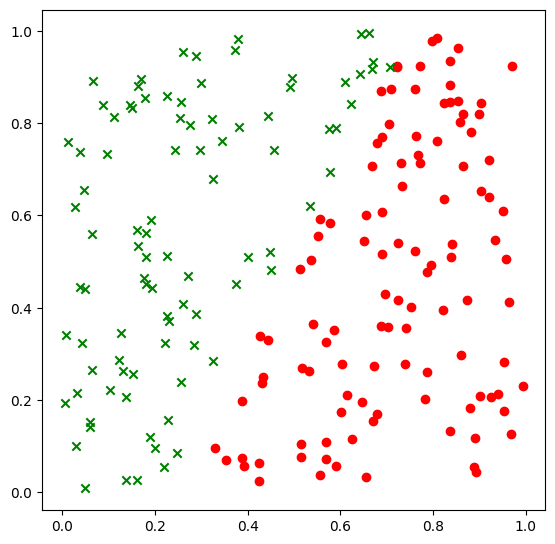

In [64]:
file_name = "ch06.npz"

def TargetFunction(x1,x2):
    y = 2*x1-0.5
    if x2 > y:
        return 1
    else:
        return 0

def CreateSampleData(m):
    file = Path(file_name)
    if file.exists():
        data = np.load(file)
        X = data["data"]
        Y = data["label"]
    else:
        X = np.random.random((200,2))
        Y = np.zeros((200,1))
        for i in range(200):
            y = TargetFunction(X[i,0], X[i,1])
            Y[i,0] = y
        np.savez(file_name, data=X, label=Y)
    return X, Y

if __name__ == '__main__':
    X,Y = CreateSampleData(200)
    fig = plt.figure(figsize=(6.5,6.5))
    for i in range(200):
        if Y[i,0] == 1:
            plt.scatter(X[i,0], X[i,1], marker='x', c='g')
        else:
            plt.scatter(X[i,0], X[i,1], marker='o', c='r')
    plt.show()

In [65]:
class NetType(Enum):
    Fitting = (1,)
    BinaryClassifier = (2,)
    MultipleClassifier = (3,)
    BinaryTanh = 4


# 线性二分类函数logistic Function
class Logistic(object):
    def forward(self, z):
        a = 1.0 / (1.0 + np.exp(-z))
        return a


# 双曲正切函数
class Tanh(object):
    def forward(self, z):
        a = 2.0 / (1.0 + np.exp(-2 * z)) - 1.0
        return a

In [66]:
class HyperParameters(object):
    def __init__(
        self, input_size, output_size, eta=0.1, max_epoch=1000, batch_size=5, eps=0.1,net_type=NetType.Fitting
    ):
        self.input_size = input_size
        self.output_size = output_size
        self.eta = eta
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.eps = eps
        self.net_type = net_type

    def toString(self):
        title = str.format("bz:{0},eta:{1}", self.batch_size, self.eta)
        return title

class LossFunction(object):
    def _init_(self,net_type):
        self.net_type = net_type

   # fcFunc: feed forward calculation
    def CheckLoss(self, A, Y):
        m = Y.shape[0]
        if self.net_type == NetType.BinaryClassifier:
            loss = self.CE2(A, Y, m)
        elif self.net_type == NetType.BinaryTanh:
            loss = self.CE2_tanh(A, Y, m)
        
        return loss
  
    def MSE(self,A,Y,count):
        LOSS = (A - Y)**2
        loss = LOSS.sum()/count/2
        return loss
    
    def CE2(self, A, Y, count):
        p1 = 1 - Y
        p2 = np.log(1 - A)
        p3 = np.log(A)

        p4 = np.multiply(p1 ,p2)
        p5 = np.multiply(Y, p3)

        LOSS = np.sum(-(p4 + p5))  #binary classification
        loss = LOSS / count
        return loss
    # end def

    # for binary tanh classifier
    def CE2_tanh(self, A, Y, count):
        #p = (1-Y) * np.log(1-A) + (1+Y) * np.log(1+A)
        p = (1-Y) * np.log((1-A)/2) + (1+Y) * np.log((1+A)/2)
        LOSS = np.sum(-p)
        loss = LOSS / count
        return loss
        

In [67]:
class TrainingHistory_1_0(object):
    def __init__(self):
        self.iteration = []
        self.loss_history = []

    def AddLossHistory(self, iteration, loss):
        self.iteration.append(iteration)
        self.loss_history.append(loss)

    def ShowLossHistory(self, hp, xmin=None, xmax=None, ymin=None, ymax=None):
        plt.plot(self.iteration, self.loss_history)
        title = hp.toString()
        plt.title(title)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        if xmin != None and ymin != None:
            plt.axis([xmin, xmax, ymin, ymax])
        plt.show()
        return title

    def GetLast(self):
        count = len(self.loss_history)
        return self.loss_history[count-1], self.w_history[count-1], self.b_history[count-1]

In [68]:
class NeuralNet(object):
    def __init__(self, hp):
        self.hp = hp
        self.W = np.zeros(
            (self.hp.input_size, self.hp.output_size)
        )  # 权重矩阵由神经网络输入输出个数决定
        self.B = np.zeros((1, self.hp.output_size))

    # 多样本计算
    def __forwardBatch(self, batch_x):
        Z = np.dot(batch_x, self.W) + self.B
        if self.hp.net_type == NetType.BinaryClassifier:
            A = Logistic().forward(Z)
            return A
        else:
            return Z

    def __backwardBatch(self, batch_x, batch_y, batch_z):
        m = batch_x.shape[0]
        dZ = batch_z - batch_y
        dB = dZ.sum(axis=0, keepdims=True) / m
        dW = np.dot(batch_x.T, dZ) / m
        return dW, dB

    def __update(self, dW, dB):
        self.W = self.W - self.hp.eta * dW
        self.B = self.B - self.hp.eta * dB

    def inference(self, x):
        return self.__forwardBatch(x)

    def __checkLoss(self, dataReader):  # 多样本损失函数计算
        X, Y = dataReader.GetWholeTrainSamples()
        m = X.shape[0]
        Z = self.__forwardBatch(X)
        LOSS = (Z - Y) ** 2
        loss = LOSS.sum() / m / 2
        return loss

    # 训练
    def train(self, dataReader, checkpoint, net_type):
        # calculate loss to decide the stop condition
        loss_history = TrainingHistory_1_0()
        loss = 10
        if self.hp.batch_size == -1:
            self.hp.batch_size = dataReader.num_train
        max_iteration = math.ceil(dataReader.num_train / self.hp.batch_size)
        checkpoint_iteration = (int)(max_iteration * checkpoint)

        for epoch in range(self.hp.max_epoch):
            print("epoch=%d" % epoch)
            dataReader.Shuffle()
            for iteration in range(max_iteration):
                # get x and y value for one sample
                batch_x, batch_y = dataReader.GetBatchTrainSamples(
                    self.hp.batch_size, iteration
                )
                # get z from x,y
                batch_z = self.__forwardBatch(batch_x)
                # calculate gradient of w and b
                dW, dB = self.__backwardBatch(batch_x, batch_y, batch_z)
                # update w,b
                self.__update(dW, dB)

                total_iteration = epoch * max_iteration + iteration
                if (total_iteration + 1) % checkpoint_iteration == 0:
                    loss = self.__checkLoss(dataReader)
                    print(epoch, iteration, loss, self.W, self.B)
                    loss_history.AddLossHistory(epoch * max_iteration + iteration, loss)
                    if loss < self.hp.eps:
                        break
                    # end if
                # end if
            # end for
            if loss < self.hp.eps:
                break
        # end for
        loss_history.ShowLossHistory(self.hp)
        print("W=", self.W)
        print("B=", self.B)

In [69]:
class SimpleDataReader(object):
    def __init__(self, data_file):
        self.train_file_name = data_file
        self.num_train = 0
        self.XTrain = None
        self.YTrain = None
        self.X_norm=None
        self.XRAW = None    # raw x
        self.YRaw = None    # raw y
    #样本随机化
    def Shuffle(self):
        seed = np.random.randint(0,100)
        np.random.seed(seed)
        XP = np.random.permutation(self.XTrain)
        np.random.seed(seed)
        YP = np.random.permutation(self.YTrain)
        self.XTrain = XP
        self.YTrain = YP
    # read data from file
    def ReadData(self):
        train_file = Path(self.train_file_name)
        if train_file.exists():
            data = np.load(self.train_file_name)
            self.XRAW = data["data"]
            self.YRAW = data["label"]
            self.num_train = self.XRAW.shape[0]
            self.XTrain = self.XRAW
            self.YTrain = self.YRAW
        else:
            raise Exception("Cannot find train file!!!")
        # end if

    # get batch training data
    def GetSingleTrainSample(self, iteration):
        x = self.XTrain[iteration]
        y = self.YTrain[iteration]
        return x, y
        
    def GetBatchTrainSamples(self, batch_size, iteration):
        start = iteration * batch_size
        end = start + batch_size
        batch_X = self.XTrain[start:end,:]
        batch_Y = self.YTrain[start:end,:]
        return batch_X, batch_Y

    def GetWholeTrainSamples(self):
        return self.XTrain, self.YTrain
    #X_new矩阵存放归一化后的数据，X_norm存放所有特征值归一化时的最小值和range值
    #计算归一化数据，即将X_raw每一列的数据归一化到0-1之间，存放到X_new中
    def NormalizeX(self):
        X_new = np.zeros(self.XRAW.shape)
        num_feature = self.XRAW.shape[1]
        self.X_norm = np.zeros((num_feature,2))
        # 按列归一化,即所有样本的同一特征值分别做归一化
        for i in range(num_feature):
            # get one feature from all examples
            col_i = self.XRAW[:,i]
            max_value = np.max(col_i)
            min_value = np.min(col_i)
            # min value
            self.X_norm[i,0] = min_value 
            # range value
            self.X_norm[i,1] = max_value - min_value 
            new_col = (col_i - self.X_norm[i,0])/(self.X_norm[i,1])
            X_new[:,i] = new_col
        #end for
        self.XTrain = X_new
        return X_new
    
    def NormalizePredicateData(self, X_raw):
        X_new=np.zeros(X_raw.shape)
        n=X_raw.shape[1]
        for i in range(n):
            col_i=X_raw[:,i]
            X_new[:,i]=(col_i-self.X_norm[i,0])/self.X_norm[i,1]
        return X_new

def ShowResult(net, reader):
    # draw example points
    X,Y = reader.GetWholeTrainSamples()
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X[:,0],X[:,1],Y)
    # draw fitting surface
    p = np.linspace(0,1)
    q = np.linspace(0,1)
    P,Q = np.meshgrid(p,q)
    R = np.hstack((P.ravel().reshape(2500,1), Q.ravel().reshape(2500,1)))
    Z = net.inference(R)
    Z = Z.reshape(50,50)
    ax.plot_surface(P,Q,Z, cmap='rainbow')
    plt.show()


In [70]:
def DrawTwoCategoryPoints(X1, X2, Y, xlabel="x1", ylabel="x2", title=None, show=False, isPredicate=False):
    colors = ['b', 'r']
    shapes = ['s', 'x']
    assert(X1.shape[0] == X2.shape[0] == Y.shape[0])
    count = X1.shape[0]
    for i in range(count):
        j = (int)(round(Y[i]))
        if j < 0:
            j = 0
        if isPredicate:
            plt.scatter(X1[i], X2[i], color=colors[j], marker='^', s=200, zorder=10)
        else:
            plt.scatter(X1[i], X2[i], color=colors[j], marker=shapes[j], zorder=10)
    # end for
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    if show:
        plt.show()


def DrawThreeCategoryPoints(X1, X2, Y_onehot, xlabel="x1", ylabel="x2", title=None, show=False, isPredicate=False):
    colors = ['b', 'r', 'g']
    shapes = ['s', 'x', 'o']
    assert(X1.shape[0] == X2.shape[0] == Y_onehot.shape[0])
    count = X1.shape[0]
    for i in range(count):
        j = np.argmax(Y_onehot[i])
        if isPredicate:
            plt.scatter(X1[i], X2[i], color=colors[j], marker='^', s=200, zorder=10)
        else:
            plt.scatter(X1[i], X2[i], color=colors[j], marker=shapes[j], zorder=10)
    #end for
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    if show:
        plt.show()

def draw_split_line(net):
    b12 = -net.B[0,0]/net.W[1,0]
    w12 = -net.W[0,0]/net.W[1,0]
    print("w12=", w12)
    print("b12=", b12)
    x = np.linspace(0,1,10)
    y = w12 * x + b12
    plt.plot(x,y)
    plt.axis([-0.1,1.1,-0.1,1.1])
    plt.show()

def draw_source_data(dataReader, show=False):
    fig = plt.figure(figsize=(6,6))
    X,Y = dataReader.GetWholeTrainSamples()
    DrawTwoCategoryPoints(X[:,0], X[:,1], Y[:,0], show=show)

def draw_predicate_data(net, threshold=0.5):
    x = np.array([0.58,0.92,0.62,0.55,0.39,0.29]).reshape(3,2)
    a = net.inference(x)
    print("A=", a)
    DrawTwoCategoryPoints(x[:,0], x[:,1], a[:,0], show=False, isPredicate=True)

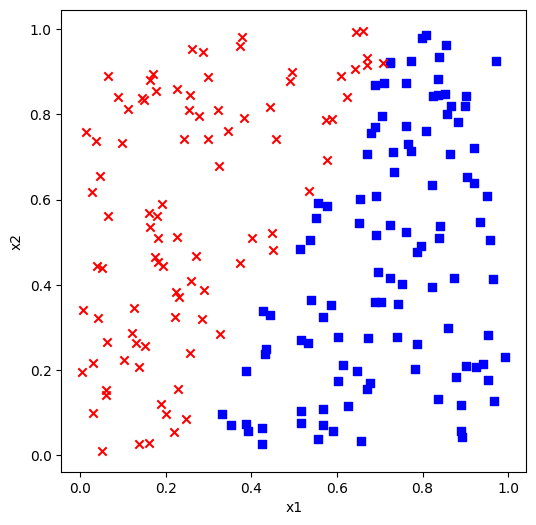

epoch=0
epoch=1
epoch=2
epoch=3
epoch=4
epoch=5
epoch=6
epoch=7
epoch=8
epoch=9
9 199 0.026495896715731524 [[-7.78951842]
 [ 3.14626277]] [[2.00108666]]
epoch=10
epoch=11
epoch=12
epoch=13
epoch=14
epoch=15
epoch=16
epoch=17
epoch=18
epoch=19
19 199 0.020159415944700297 [[-10.56504832]
 [  4.51854874]] [[2.63942059]]
epoch=20
epoch=21
epoch=22
epoch=23
epoch=24
epoch=25
epoch=26
epoch=27
epoch=28
epoch=29
29 199 0.016786020129596527 [[-12.34822914]
 [  5.57988167]] [[3.19246562]]
epoch=30
epoch=31
epoch=32
epoch=33
epoch=34
epoch=35
epoch=36
epoch=37
epoch=38
epoch=39
39 199 0.014988634970014325 [[-13.77385578]
 [  6.40066733]] [[3.50137647]]
epoch=40
epoch=41
epoch=42
epoch=43
epoch=44
epoch=45
epoch=46
epoch=47
epoch=48
epoch=49
49 199 0.013804576426809354 [[-15.01103825]
 [  7.00894689]] [[3.71985876]]
epoch=50
epoch=51
epoch=52
epoch=53
epoch=54
epoch=55
epoch=56
epoch=57
epoch=58
epoch=59
59 199 0.012866108264649588 [[-16.06614605]
 [  7.5864582 ]] [[3.93384661]]
epoch=60
epoch=61

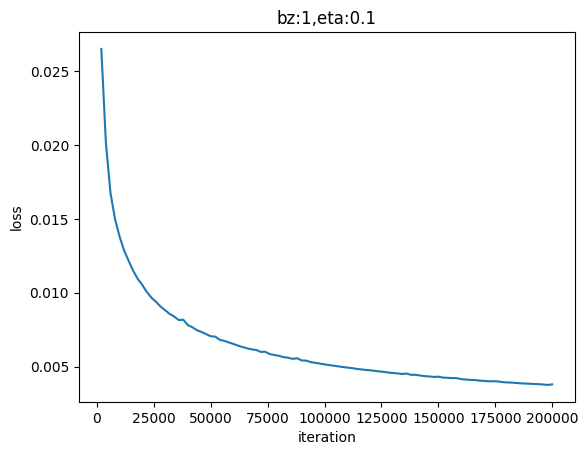

W= [[-44.02667034]
 [ 22.27268903]]
B= [[10.24831396]]
A= [[0.99453396]
 [0.00817681]
 [0.38627257]]
A= [[0.99453396]
 [0.00817681]
 [0.38627257]]
w12= 1.9767110418812754
b12= -0.46012917171001094


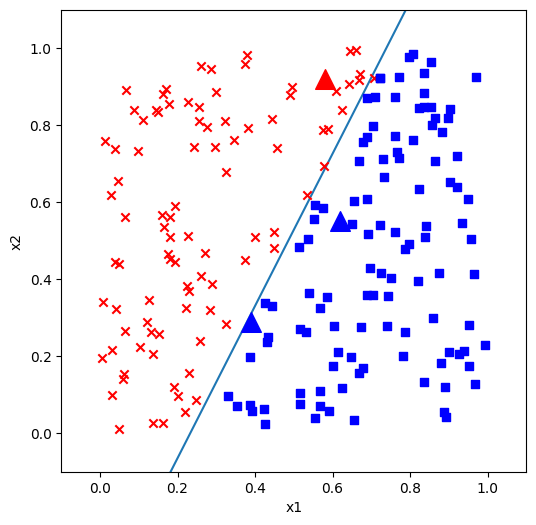

In [71]:
#主函数

#file_name = "ch06.npz"
#data
reader = SimpleDataReader(file_name)
reader.ReadData()
draw_source_data(reader, show=True)
#net
num_input = 2
num_output = 1
params = HyperParameters(num_input, num_output, eta=0.1, max_epoch=1000, batch_size=1, eps = 1e-3,net_type=NetType.BinaryClassifier)
net = NeuralNet(params)
net.train(reader, checkpoint=10, net_type=NetType.BinaryClassifier)
# inference
x_predicate = np.array([0.58,0.92,0.62,0.55,0.39,0.29]).reshape(3,2)
a=net.inference(x_predicate)
print("A=", a)

draw_source_data(reader, show=False)
draw_predicate_data(net)
draw_split_line(net)
plt.show()